In [38]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
from PIL import Image
import random

from sklearn.preprocessing import LabelEncoder

from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential

import tensorflow as tf


In [39]:
df = pd.read_csv("C:/Users/tekri/1stop/google landmark detection/train.csv/train.csv")
base_path ="./images/"

In [40]:
df

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
...,...,...
1048570,ae9609cad3a943fa,135467
1048571,bacd5740d47f3b04,135467
1048572,cc890b31987c36a2,135467
1048573,ce84a8aacbb7d15c,135467


In [41]:
samples = 20000
df = df.loc[df['id'].str.startswith('00', na=False), :]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [42]:
num_classes

3539

In [43]:
num_data

4041

In [44]:
data = pd.DataFrame(df["landmark_id"].value_counts())

data.reset_index(inplace=True)
data.columns=['landmark_id','count']
data.head()

,landmark_id,count
0,83144,14
1,126637,7
2,46705,6
3,9673,6
4,109169,6


In [45]:
data.tail()

,landmark_id,count
3534,46538,1
3535,46597,1
3536,46609,1
3537,46677,1
3538,135395,1


In [46]:
data.columns=['landmark_id','count']

In [47]:
data['count'].describe()

count    3539.000000
mean        1.141848
std         0.509600
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        14.000000
Name: count, dtype: float64

(array([3.538e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

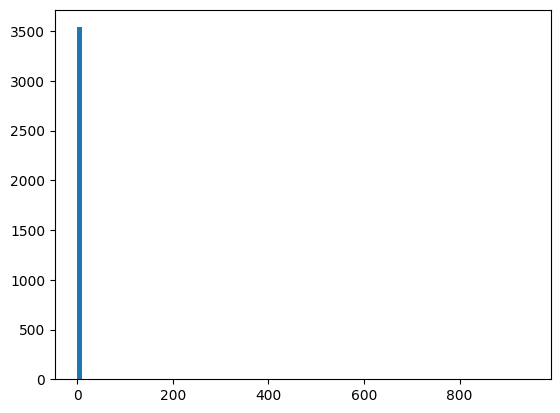

In [48]:
plt.hist(data['count'], 100, range = (0,944), label='test')


In [49]:
data['count'].between(0,5).sum()

3534

In [50]:
data['count'].between(5,10).sum()

9

(array([2., 1., 1., ..., 1., 1., 2.]),
 array([2.70000e+01, 6.00000e+01, 1.24000e+02, ..., 1.35308e+05,
        1.35318e+05, 1.35395e+05]),
 <BarContainer object of 3538 artists>)

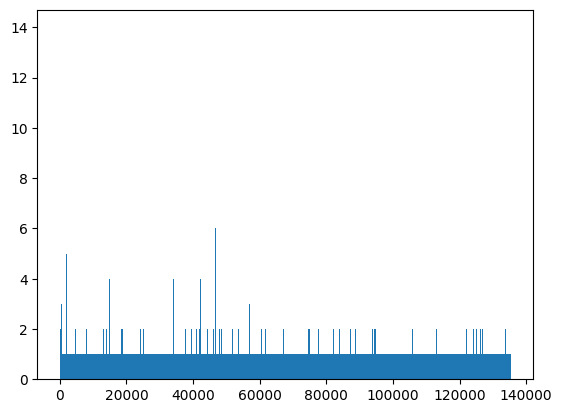

In [51]:
plt.hist(df["landmark_id"], bins=df["landmark_id"].unique())

In [52]:
#Training of Model
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

LabelEncoder()

In [53]:
df.head()

,id,landmark_id
119,00cba0067c078490,27
120,00f928e383e1d121,27
796,009ecdb56b5e9adb,60
1089,00d5d47528839144,124
1133,00e9003a381ab809,134


In [54]:
def encode_label(lbl):
    return lencoder.transform(lbl)

In [55]:
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

In [56]:
def get_image_from_number(num):
    fname, label = df.loc[num, :]
    fname = fname + '.jpg'
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path, path))
    return im, label

4 sample images from random class


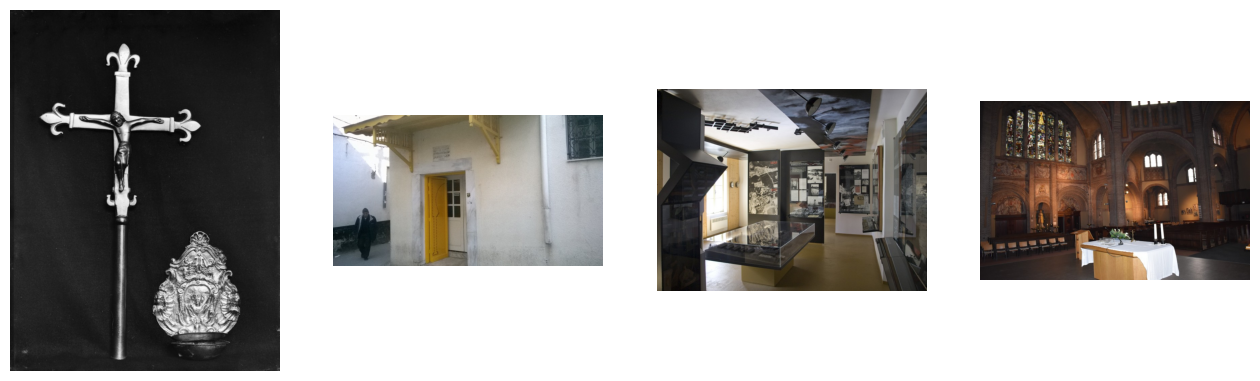

In [57]:
print("4 sample images from random class")
fig = plt.figure(figsize=(16,16))
for i in range(1,5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = base_path + '/' + ri[0] + '/' + ri[1] + '/' + ri[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1,4,i)
    plt.imshow(img)
    plt.axis('off')
plt.show()
    

In [58]:
tf.compat.v1.disable_eager_execution()

In [59]:
#parameters
learning_rate = 0.0001
decay_speed   = 1e-6
momentum      = 0.09
loss_function = "sparse_categorical_crossentropy"
source_model  = VGG19(weights = None)
drop_layer    = Dropout(0.5)
drop_layer2   = Dropout(0.5)

In [60]:
model = Sequential()
for layer in source_model.layers[:1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
model.add(Dense(num_classes, activation = "softmax"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 224, 224, 3539) │        14,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,156 (55.30 KB)

 Trainable params: 14,156 (55.30 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
optim1 = keras.optimizers.RMSprop(learning_rate = learning_rate)
model.compile(optimizer=optim1,
              loss=loss_function,
              metrics = ["accuracy"])

In [62]:
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)

In [63]:
def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []

    end_img = start+batch_size
    if(end_img) > len(dataframe):
        end_img = len(dataframe)

    for idx in range(start, end_img):
        n=idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224,224)) / 255.0
        image_array.append(im)
        label_array.append(label)

    label_array = encode_label(label_array)

    return np.array(image_array), np.array(label_array)

In [64]:
batch_size = 16
epoch_shuffle = True
weight_class = True
epochs = 1

#split
train, val = np.split(df.sample(frac=1),[int(0.8*len(df))])
print(len(train))
print(len(val))

3232
809


c:\Users\tekri\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [65]:
for e in range(epochs):
    print("Epoch :" + str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)

        model.train_on_batch(X_train, y_train)
    
model.save("Model")

Epoch :1/1


TypeError: get_image_from_number() takes 1 positional argument but 2 were given

In [ ]:
#test
batch_size = 16

errors = 0
good_preds = []
bad_preds = []

for it in range(int(np.ceil(len(val)/batch_size))):
    X_val, y_val = get_batch(val, it*batch_size, batch_size)

    result = model.predict(X_val)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        if cla[idx] != y_val[idx]:
            errors = errors +1
            bad_preds.append([batch_size*it + idx], cla[idx], res[cla[idx]])
        else:
            good_preds.append([batch_size*it + idx], cla[idx], res[cla[idx]])


NameError: name 'np' is not defined

In [ ]:
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse = True))

In [ ]:
len(good_preds)

0

In [ ]:
fig=plt.figure(figsize=(16,16))
for i in range(1,6):
    n = int(good_preds[0])
    img, lbl = get_image_from_number(n, val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i-6)    
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "\nClassified as: " + str(decode_label(lbl2)))
    plt.axis('off')
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1600x1600 with 0 Axes>